In [1]:
import sys
sys.path.append('/mnt/c/Users/jvita/scripts/s-meam/')
sys.path.append('/home/jvita/scripts/tmp/s-meam/')

import numpy as np
import src.meam
from src.potential_templates import Template
from src.meam import MEAM

BASE_PATH = '/home/jvita/scripts/s-meam/'
BASE_PATH = '/mnt/c/Users/jvita/scripts/'
LOAD_PATH = BASE_PATH + 'data/fitting_databases/pinchao/'

potential = MEAM.from_file(LOAD_PATH + 'TiO.meam.spline')

x_pvec, seed_pvec, indices = src.meam.splines_to_pvec(
    potential.splines)

potential_template = Template(
    pvec_len=116,
    u_ranges = [(-1, 1), (-1, 1)],
    spline_ranges=[(-1, 4), (-0.5, 0.5), (-1, 1), (-9, 3), (-30, 15),
                   (-0.5, 1), (-0.2, -0.4), (-2, 3), (-7.5, 12.5),
                   (-8, 2), (-1, 1), (-1, 0.2)],
    spline_indices=[(0, 15), (15, 22), (22, 37), (37, 50), (50, 57),
                     (57, 63), (63, 70), (70, 82), (82, 89),
                     (89, 99), (99, 106), (106, 116)]
)

potential_template.pvec = seed_pvec.copy()

mask = np.ones(potential_template.pvec_len)

mask[:15] = 0 # phi_Ti

potential_template.pvec[19] = 0; mask[19] = 0 # rhs phi_TiO knot
potential_template.pvec[21] = 0; mask[21] = 0 # rhs phi_TiO deriv

mask[22:37] = 0 # phi_O
mask[37:50] = 0 # rho_Ti

potential_template.pvec[54] = 0; mask[54] = 0 # rhs rho_O knot
potential_template.pvec[56] = 0; mask[56] = 0 # rhs rho_O deriv

mask[57:63] = 0 # U_Ti
mask[70:82] = 0 # f_Ti

potential_template.pvec[86] = 0; mask[86] = 0 # rhs f_O knot
potential_template.pvec[88] = 0; mask[88] = 0 # rhs f_O deriv

mask[89:99] = 0 # g_Ti
mask[106:116] = 0 # g_O

potential_template.active_mask = mask

In [3]:
guess_pvec = np.genfromtxt(BASE_PATH + 's-meam/pop.dat201')[0]
guess_pots = potential_template.insert_active_splines(np.atleast_2d(guess_pvec))
guess_pots.shape

(1, 116)

In [4]:
true_pvec = seed_pvec
seed_pvec.shape

(116,)

In [5]:
labels = ['A-A', 'A-B', 'B-B']

titles= [r"$\phi_A$", r"$\phi_{AB}$", r"$\phi_B$",
         r"$\rho_A$", r"$\rho_B$",
         r"$U_A$", r"$U_B$", r"$f_A$", r"$f_B$", r"$g_A$", r"$g_{AB}$",
         r"$g_B$"]

x_rng_tups = [(1.74, 5.5, 13), (1.9, 5.5, 5),
        (1.74, 5.5, 13), (2.05, 4.4, 11),
        (1.9, 5.5, 5), (-55, -24, 4),
        (-24, 8.3, 5), (2.05, 4.4, 10),
        (1.9, 5.5, 5), (-1, 1, 8),
        (-1, 1, 5), (-1, 1, 8)]

x_rngs = [np.linspace(t[0], t[1], t[2]) for t in x_rng_tups]
x_plts = [np.linspace(t[0], t[1], 100) for t in x_rng_tups]


[15, 22, 37, 50, 57, 63, 70, 82, 89, 99, 106]


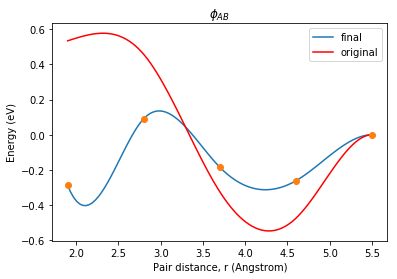

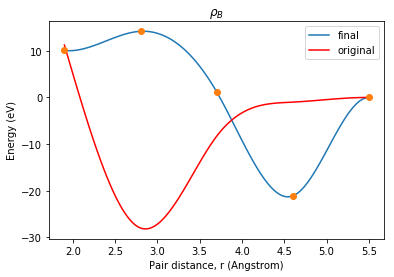

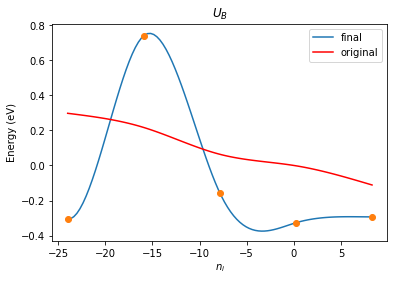

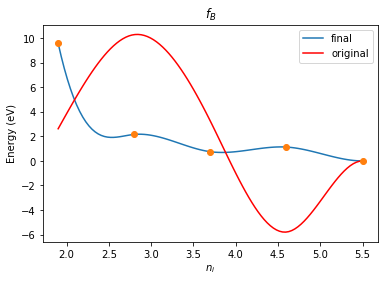

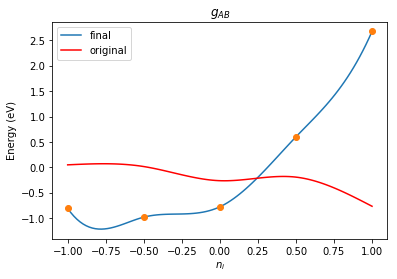

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

split_indices = [el[0] for el in potential_template.spline_indices[1:]]
print(split_indices)

dat_guess = np.split(guess_pots, split_indices, axis=1)
dat_true = np.split(true_pvec, split_indices)

true_derivs = [el[-2:] for el in dat_true]

# for i in range(len(titles)):
for i in [1, 4, 6, 8, 10]:
    fig, ax = plt.subplots()
    plt.title(titles[i])

    for j in range(dat_guess[i].shape[0]):

        # ep = all_eps[i]

        y_guess, dy_guess = dat_guess[i][j, :-2], dat_guess[i][j, -2:]

        cs1 = CubicSpline(x_rngs[i], y_guess)
        cs1 = CubicSpline(x_rngs[i], y_guess, bc_type=((1,dy_guess[0]), (1,dy_guess[1])))
        cs2 = CubicSpline(x_rngs[i], dat_true[i][:-2], bc_type=((1,true_derivs[i][0]), (1,true_derivs[i][1])))

        # if (i == 3) or (i == 4):
        #     cs3 = CubicSpline(x_rngs[i], 10*dat_true[i], bc_type=((1,true_derivs[i][0]), (1,true_derivs[i][1])))

        # shown_label = 'guess' if i == 0 else None
        # shown_label_true = 'true' if i == 0 else None
        shown_label = shown_label_true = None
        if j == 0:
            shown_label = "final"
            shown_label_true = "original"
        elif j == 1: shown_label = "original"

        ax.plot(x_plts[i], cs1(x_plts[i]), label=shown_label)
        ax.plot(x_plts[i], cs2(x_plts[i]), 'r', label=shown_label_true)
        # if (i == 3) or (i == 4):
#             plt.plot(x_plts[i], cs3(x_plts[i]), 'g', label='scaled')
        ax.plot(x_rngs[i], y_guess, 'o')

    plt.legend()

    if i < 5:
        plt.xlabel("Pair distance, r (Angstrom)")
    else:
        plt.xlabel(r"$n_i$")
    plt.ylabel("Energy (eV)")

    plt.show()
#     plt.savefig('plots/super_long_seed1'+str(i)+'.png')
    plt.close()


In [88]:
(i, x_rngs[i], y_guess)

(6,
 array([-0.2 , -0.25, -0.3 , -0.35, -0.4 ]),
 array([1361.08368708,    1.45653683,   -2.19587041,    1.63211889,
           2.3413972 ]))

In [82]:
[len(el) for el in x_rngs]

[13, 5, 13, 11, 5, 4, 5, 10, 5, 8, 5, 8]

In [89]:
np.linspace(-4, 3, 5)

array([-4.  , -2.25, -0.5 ,  1.25,  3.  ])

In [106]:
guess_pot

array([ 2.12372860e+00,  1.08285073e+00,  1.39811873e+00,  2.39610370e+00,
        1.70450460e+00, -7.61431127e-01,  3.68589967e+00,  2.82946552e+00,
        2.32982935e+00,  1.04519391e+00, -3.71008894e-01, -9.70640582e-01,
       -1.94634287e-01,  6.96015402e-01,  2.59694082e+00,  1.02165095e+01,
        1.26996802e+02,  2.46829458e+02,  1.76993837e+02,  0.00000000e+00,
       -1.33892109e+02,  0.00000000e+00, -1.92835710e-01, -8.04904024e-01,
       -6.47009803e-01, -2.47225554e-01,  5.08558923e-01,  2.49781480e-01,
       -5.68697349e-01,  7.66941938e-01,  9.85089957e-01, -3.66106442e-01,
       -9.74764377e-01, -2.83116592e-01, -4.39717864e-01, -8.18247525e-01,
       -2.76463230e-01, -4.65488784e+00, -5.34902718e+00, -2.41687311e+00,
        7.72272150e-01,  2.65391342e+00, -5.15977980e+00, -1.97424156e+00,
        2.38522723e-01, -6.20625083e+00,  1.73483275e+00, -1.32207736e+00,
       -3.31751518e-01, -8.14004793e+00, -3.78662284e+01,  3.44955298e+01,
        4.04907455e+01,  